# Customer lifetime value predictions

In [251]:
import pandas as pd


df = pd.read_excel('./Data/online_retail.xlsx')
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [252]:
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]
df['CustomerID'] = df['CustomerID'].astype('int')
df['Revenue'] = df['Quantity'] * df['UnitPrice']

# customer df with country 

In [253]:
customer_df =df.groupby('CustomerID')['Country'].nunique().reset_index()
customer_df[customer_df['Country']>1]

,CustomerID,Country
20,12370,2
38,12394,2
56,12417,2
60,12422,2
67,12429,2
69,12431,2
90,12455,2
92,12457,2


# Customer & revenue trends

In [254]:
df1=df.groupby('InvoiceDate', as_index=False)['Revenue'].sum()
df2=df.groupby('InvoiceDate', as_index=False)['CustomerID'].nunique()
viz_df = df1.merge(df2, left_on="InvoiceDate", right_on="InvoiceDate")
viz_df = viz_df.rename(columns={'CustomerID':'CustomerCount'})
viz_df['InvoiceDate'] = pd.to_datetime(viz_df['InvoiceDate'])



In [255]:
viz_df[['InvoiceDate']].min()

InvoiceDate   2010-12-01
dtype: datetime64[ns]

In [256]:
viz_df[['InvoiceDate']].max()

InvoiceDate   2011-12-09
dtype: datetime64[ns]

<Axes: xlabel='InvoiceDate'>

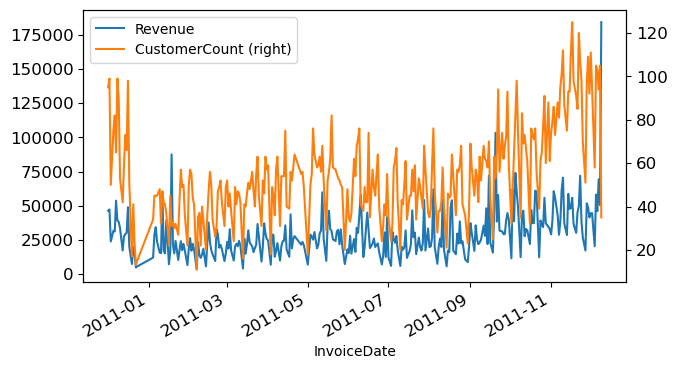

In [257]:
import matplotlib.pyplot as plt
viz_df.set_index('InvoiceDate', inplace=True)
viz_df.plot(figsize=(7,4),fontsize=12, secondary_y='CustomerCount')

# Historical Average

In [258]:
import pandas as pd
from datetime import datetime
import numpy as np

date_rng = pd.date_range(start='2010-11-30', end='2011-11-30', freq='M')
churn =  {"Month":[],"ChurnRate":[], "AvgRevenue":[]}

#append first month without churn rate
this_period  =df[(df['InvoiceDate']> date_rng[0].date()) & (df['InvoiceDate']<= date_rng[1].date()) ]['CustomerID'].unique()
total_revenue =df[(df['InvoiceDate']> date_rng[0].date()) & (df['InvoiceDate']<= date_rng[1].date()) ]['Revenue'].sum()

churn["Month"].append(date_rng[1])
churn["ChurnRate"].append(np.nan)
churn["AvgRevenue"].append(int(total_revenue/len(this_period)))

#loop through the rest of the months
for i in range(len(date_rng)):
    try:
        last_period =df[(df['InvoiceDate']> date_rng[i].date()) & (df['InvoiceDate']<= date_rng[i+1].date()) ]['CustomerID'].unique()
        this_period  =df[(df['InvoiceDate']> date_rng[i+1].date()) & (df['InvoiceDate']<= date_rng[i+2].date()) ]['CustomerID'].unique()
        total_revenue =df[(df['InvoiceDate']> date_rng[i+1].date()) & (df['InvoiceDate']<= date_rng[i+2].date()) ]['Revenue'].sum()
        retained = np.intersect1d(last_period, this_period)
        churn["Month"].append(date_rng[i+2])
        churn["ChurnRate"].append((int((1-(len(retained)/len(last_period)))*100)))
        churn["AvgRevenue"].append(int(total_revenue/len(this_period)))
    except:
        pass

In [259]:
churn_df = pd.DataFrame(churn)
churn_df

,Month,ChurnRate,AvgRevenue
0,2010-12-31,NaN,647
1,2011-01-31,63.0,768
2,2011-02-28,64.0,589
3,2011-03-31,61.0,611
4,2011-04-30,68.0,548
5,2011-05-31,57.0,642
6,2011-06-30,61.0,667
7,2011-07-31,63.0,632
8,2011-08-31,59.0,690
9,2011-09-30,54.0,752


In [260]:
churn_df.mean().round(0)

ChurnRate      60.0
AvgRevenue    667.0
dtype: float64

## Lifetime months

In [261]:
round(100/60,2)

1.67

## Lifetime value

In [262]:
round(667*(100/60))

1112

# RFM

In [263]:
import numpy as np

cus_df = df.groupby('CustomerID')['Country'].max().reset_index()

def process_data(train_df, final_date):
    max_date = train_df.groupby('CustomerID', as_index=False).agg({'InvoiceDate':'max'})
    max_date = max_date.rename(columns={"InvoiceDate": "MaxDate"}).set_index('CustomerID')
    min_date = train_df.groupby('CustomerID', as_index=False).agg({'InvoiceDate':'min'})
    min_date = min_date.rename(columns={"InvoiceDate": "MinDate"}).set_index('CustomerID')
    freqeuncy = train_df.groupby('CustomerID', as_index=False).agg({'Revenue':'count'})
    freqeuncy = freqeuncy.rename(columns={"Revenue": "Freqeuncy"}).set_index('CustomerID')
    monetary = train_df.groupby('CustomerID', as_index=False).agg({'Revenue':'sum'})
    monetary = monetary.rename(columns={"Revenue": "Monetary"}).set_index('CustomerID')

    rmf_df = max_date.merge(min_date, left_index=True, right_index=True)\
        .merge(freqeuncy, left_index=True, right_index=True)\
            .merge(monetary, left_index=True, right_index=True).reset_index()

    rmf_df['CutoffDate'] = final_date
    rmf_df[['MinDate','MaxDate','CutoffDate']] = rmf_df[['MinDate','MaxDate', 'CutoffDate']].apply(pd.to_datetime)
    #calculate difference between dates
    rmf_df['Tenure'] = (rmf_df['CutoffDate'] - rmf_df['MinDate'])  / np.timedelta64(1, 'D')
    rmf_df['Recency'] = (rmf_df['CutoffDate'] - rmf_df['MaxDate'])  / np.timedelta64(1, 'D')
    rmf_df['Churn'] = rmf_df['Recency'].apply(lambda x: 1 if x >30 else 0)

    country_rmf_df =rmf_df.merge(cus_df, on=['CustomerID'])
    country_rmf_df['CountryGroup'] = country_rmf_df['Country'].apply(lambda x: 'United Kingdom' if x =='United Kingdom' else 'Others')
    country_rmf_df['TenureMonth'] =  country_rmf_df['Tenure']/30.5
    country_rmf_df['TenureMonth'] = country_rmf_df['TenureMonth'].astype('int')
    return country_rmf_df

In [264]:
cutoff_date = pd.to_datetime("2011-09-01").date()
end_date = pd.to_datetime("2011-12-01").date()
train_df = process_data(df.loc[df['InvoiceDate']<=cutoff_date],cutoff_date )
test_df = process_data(df.loc[df['InvoiceDate']<=end_date], end_date)

In [265]:
train_df

,CustomerID,MaxDate,MinDate,Freqeuncy,Monetary,CutoffDate,Tenure,Recency,Churn,Country,CountryGroup,TenureMonth
0,12346,2011-01-18,2011-01-18,1,77183.60,2011-09-01,226.0,226.0,1,United Kingdom,United Kingdom,7
1,12347,2011-08-02,2010-12-07,124,2790.86,2011-09-01,268.0,30.0,0,Iceland,Others,8
2,12348,2011-04-05,2010-12-16,28,1487.24,2011-09-01,259.0,149.0,1,Finland,Others,8
3,12350,2011-02-02,2011-02-02,17,334.40,2011-09-01,211.0,211.0,1,Norway,Others,6
4,12352,2011-03-22,2011-02-16,38,1561.81,2011-09-01,197.0,163.0,1,Norway,Others,6
...,...,...,...,...,...,...,...,...,...,...,...,...
3319,18280,2011-03-07,2011-03-07,10,180.60,2011-09-01,178.0,178.0,1,United Kingdom,United Kingdom,5
3320,18281,2011-06-12,2011-06-12,7,80.82,2011-09-01,81.0,81.0,1,United Kingdom,United Kingdom,2
3321,18282,2011-08-05,2011-08-05,7,100.21,2011-09-01,27.0,27.0,0,United Kingdom,United Kingdom,0
3322,18283,2011-07-14,2011-01-06,400,985.77,2011-09-01,238.0,49.0,1,United Kingdom,United Kingdom,7


# Kaplan Meier

In [266]:
from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines.statistics import pairwise_logrank_test

kmf = KaplanMeierFitter()
 
T=train_df['TenureMonth']
C=train_df['Churn'].astype(float)
 
kmf.fit(T,C)

<lifelines.KaplanMeierFitter:"KM_estimate", fitted with 3324 total observations, 938 right-censored observations>

<Axes: title={'center': 'Kaplan-Meier Survival Curve'}, xlabel='timeline'>

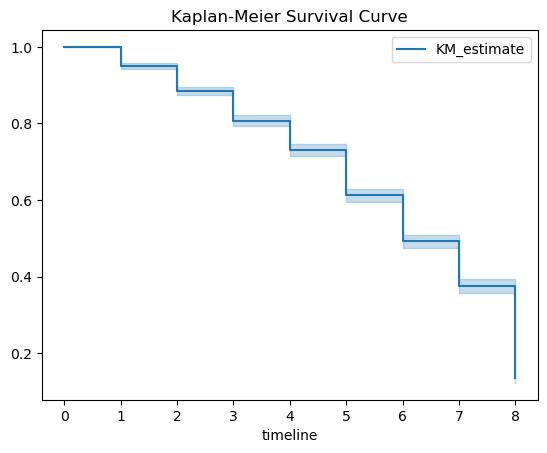

In [267]:
kmf.plot(title='Kaplan-Meier Survival Curve')

In [268]:
kmf.median_survival_time_

6.0

In [269]:
pd.DataFrame(kmf.survival_function_at_times(range(0,9)))

,KM_estimate
0,1.000000
1,0.950269
2,0.885529
3,0.807538
4,0.731024
5,0.612020
6,0.492099
7,0.376176
8,0.135593


In [270]:
def get_kmf_payback_df():
  irr = 0
  cohort_df = pd.concat([pd.DataFrame([1.00]),kmf.survival_function_at_times(range(1,8))])\
                .rename(columns={0:'Survival Probability'})
  cohort_df['Month'] = cohort_df.index.astype('int')
  cohort_df['Monthly Revenue'] = 667 #heuristic method in Part 1
  cohort_df['Avg Expected Monthly Revenue'] = round(cohort_df['Survival Probability'] \
                                                    * cohort_df['Monthly Revenue'],2)
  cohort_df['Cumulative Revenue (LTV)'] = cohort_df['Avg Expected Monthly Revenue'].cumsum()
  cohort_df['Month'] = cohort_df['Month'] + 1
  return cohort_df[['Month','Survival Probability','Monthly Revenue','Avg Expected Monthly Revenue',\
                    'Cumulative Revenue (LTV)']].set_index('Month')

kmf_survival_lookup =get_kmf_payback_df().reset_index()
kmf_survival_lookup


,Month,Survival Probability,Monthly Revenue,Avg Expected Monthly Revenue,Cumulative Revenue (LTV)
0,1,1.000000,667,667.00,667.00
1,2,0.950269,667,633.83,1300.83
2,3,0.885529,667,590.65,1891.48
3,4,0.807538,667,538.63,2430.11
4,5,0.731024,667,487.59,2917.70
5,6,0.612020,667,408.22,3325.92
6,7,0.492099,667,328.23,3654.15
7,8,0.376176,667,250.91,3905.06


In [271]:
kmf_survival_lookup =get_kmf_payback_df().reset_index()
kmf_df = test_df[test_df['TenureMonth'].isin([0,1,2])]\
    .merge(kmf_survival_lookup, left_on=['TenureMonth'], right_on='Month')

from sklearn.metrics import mean_absolute_error
mean_absolute_error(kmf_df['Monetary'], kmf_df['Cumulative Revenue (LTV)'])

623.5716118721461

In [272]:
kmf_df['Monetary'].mean()

668.2255418569254

The log-rank test is a chi-square test that is used to test the null hypothesis that two or more survival curves are statistically equivalent. We use the country group to model two survival curves.

In [273]:
import matplotlib.pyplot as plt
# Helper function for plotting Kaplan-Meier curves at the covariate level
def plot_km(col):
  ax = plt.subplot(111)
  for r in train_df[col].unique():
    ix = train_df[col] == r
    kmf.fit(T[ix], C[ix],label=r)
    kmf.plot(ax=ax)
    
# Helper function for printing out Log-rank test results
def print_logrank(col):
  log_rank = pairwise_logrank_test(train_df['TenureMonth'], train_df[col], train_df['Churn'])
  return log_rank.summary

print_logrank('CountryGroup')

,,test_statistic,p,-log2(p)
Others,United Kingdom,0.603134,0.437385,1.193025


As seen above, the p-value in our log-rank test for the country group is greater than 0.05 and therefore, we accept the null hypothesis that the two groups are statistically equivalent.

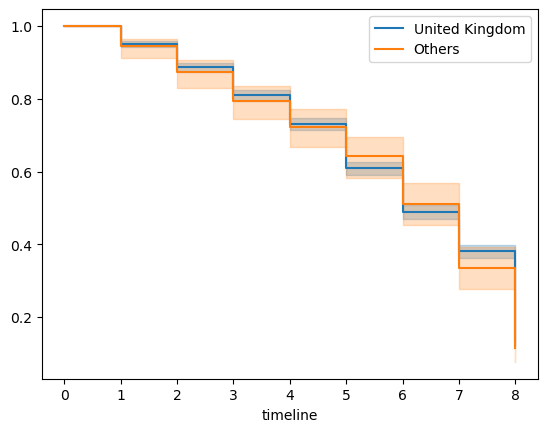

In [274]:
plot_km('CountryGroup')

In [275]:
kmf.median_survival_time_

7.0

In [276]:
def get_survival_probs(col,val):
  ix = train_df[col] == val
  return kmf.fit(T[ix],C[ix],label=val)  

In [277]:
sp_internet_dsl = get_survival_probs('Country','United Kingdom')

In [278]:
pd.DataFrame(sp_internet_dsl.survival_function_at_times(range(0,10)))

,United Kingdom
0,1.000000
1,0.950963
2,0.886833
3,0.808953
4,0.731823
5,0.608913
6,0.490033
7,0.380571
8,0.137753
9,0.137753


# Cox

In [279]:
train_df

,CustomerID,MaxDate,MinDate,Freqeuncy,Monetary,CutoffDate,Tenure,Recency,Churn,Country,CountryGroup,TenureMonth
0,12346,2011-01-18,2011-01-18,1,77183.60,2011-09-01,226.0,226.0,1,United Kingdom,United Kingdom,7
1,12347,2011-08-02,2010-12-07,124,2790.86,2011-09-01,268.0,30.0,0,Iceland,Others,8
2,12348,2011-04-05,2010-12-16,28,1487.24,2011-09-01,259.0,149.0,1,Finland,Others,8
3,12350,2011-02-02,2011-02-02,17,334.40,2011-09-01,211.0,211.0,1,Norway,Others,6
4,12352,2011-03-22,2011-02-16,38,1561.81,2011-09-01,197.0,163.0,1,Norway,Others,6
...,...,...,...,...,...,...,...,...,...,...,...,...
3319,18280,2011-03-07,2011-03-07,10,180.60,2011-09-01,178.0,178.0,1,United Kingdom,United Kingdom,5
3320,18281,2011-06-12,2011-06-12,7,80.82,2011-09-01,81.0,81.0,1,United Kingdom,United Kingdom,2
3321,18282,2011-08-05,2011-08-05,7,100.21,2011-09-01,27.0,27.0,0,United Kingdom,United Kingdom,0
3322,18283,2011-07-14,2011-01-06,400,985.77,2011-09-01,238.0,49.0,1,United Kingdom,United Kingdom,7


In [280]:
encode_cols = ['CountryGroup']
 
encoded_pd = pd.get_dummies(train_df,
               columns=encode_cols,
               prefix=encode_cols,
               drop_first=False)
 
survival_pd = encoded_pd[['Churn','TenureMonth','CountryGroup_United Kingdom','CountryGroup_Others']]
survival_pd.head()

,Churn,TenureMonth,CountryGroup_United Kingdom,CountryGroup_Others
0,1,7,1,0
1,0,8,0,1
2,1,8,0,1
3,1,6,0,1
4,1,6,0,1


In [281]:
encoded_pd

,CustomerID,MaxDate,MinDate,Freqeuncy,Monetary,CutoffDate,Tenure,Recency,Churn,Country,TenureMonth,CountryGroup_Others,CountryGroup_United Kingdom
0,12346,2011-01-18,2011-01-18,1,77183.60,2011-09-01,226.0,226.0,1,United Kingdom,7,0,1
1,12347,2011-08-02,2010-12-07,124,2790.86,2011-09-01,268.0,30.0,0,Iceland,8,1,0
2,12348,2011-04-05,2010-12-16,28,1487.24,2011-09-01,259.0,149.0,1,Finland,8,1,0
3,12350,2011-02-02,2011-02-02,17,334.40,2011-09-01,211.0,211.0,1,Norway,6,1,0
4,12352,2011-03-22,2011-02-16,38,1561.81,2011-09-01,197.0,163.0,1,Norway,6,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3319,18280,2011-03-07,2011-03-07,10,180.60,2011-09-01,178.0,178.0,1,United Kingdom,5,0,1
3320,18281,2011-06-12,2011-06-12,7,80.82,2011-09-01,81.0,81.0,1,United Kingdom,2,0,1
3321,18282,2011-08-05,2011-08-05,7,100.21,2011-09-01,27.0,27.0,0,United Kingdom,0,0,1
3322,18283,2011-07-14,2011-01-06,400,985.77,2011-09-01,238.0,49.0,1,United Kingdom,7,0,1


In [282]:
survival_pd.loc[:,'Churn'] = survival_pd.loc[:,'Churn'].astype('float')
survival_pd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3324 entries, 0 to 3323
Data columns (total 4 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        3324 non-null   float64
 1   TenureMonth                  3324 non-null   int64  
 2   CountryGroup_United Kingdom  3324 non-null   uint8  
 3   CountryGroup_Others          3324 non-null   uint8  
dtypes: float64(1), int64(1), uint8(2)
memory usage: 84.4 KB


/var/folders/tw/8wdkdtvs1fv8ftrnn4f5vt540000gn/T/ipykernel_75904/2656172636.py:1: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  survival_pd.loc[:,'Churn'] = survival_pd.loc[:,'Churn'].astype('float')


In [283]:
from lifelines.fitters.coxph_fitter import CoxPHFitter
from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter

cph = CoxPHFitter(alpha=0.01,penalizer=0.01)
cph.fit(survival_pd, 'TenureMonth', 'Churn')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 3324 total observations, 938 right-censored observations>
             duration col = 'TenureMonth'
                event col = 'Churn'
                penalizer = 0.01
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 3324
number of events observed = 2386
   partial log-likelihood = -17409.00
         time fit was run = 2023-05-21 09:03:19 UTC

---
                              coef  exp(coef)   se(coef)   coef lower 99%   coef upper 99%  exp(coef) lower 99%  exp(coef) upper 99%
covariate                                                                                                                           
CountryGroup_United Kingdom  -0.03       0.97       0.41            -1.09             1.03                 0.34                 2.81
CountryGroup_Others           0.03       1.03       0.41            -1.03             1.09                 0.36                 2.97

                              cmp to     z    p   -log2(p)
covariate                                                 
CountryGroup_United Kingdom     0.00 -0.07 0.95       0.08
CountryGroup_Others             0.00  0.07 0.95       0.08
---
Concordance = 0.50
Partial AIC = 34822.00
log-likelihood ratio test = 0.66 on 2 df
-log2(p) of ll-ratio test = 0.47

<Axes: xlabel='HR (99% CI)'>

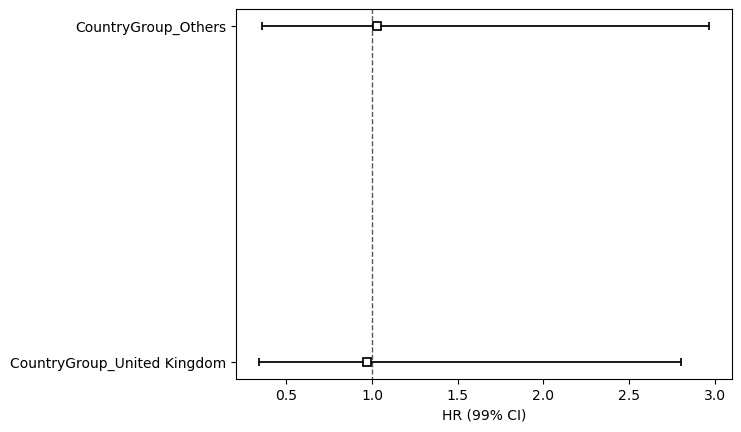

In [284]:
cph.plot(hazard_ratios=True)

In [285]:
cph.check_assumptions(survival_pd,p_value_threshold=0.05,show_plots=True)

Proportional hazard assumption looks okay.


[]

In [286]:
cph.predict_survival_function(widget_dict_df)

,0
0.0,1.000000
1.0,0.950399
2.0,0.886416
3.0,0.810034
4.0,0.735192
5.0,0.622405
6.0,0.509384
7.0,0.400322
8.0,0.207972


In [287]:
 widget_dict= {'CountryGroup_United Kingdom':0, 'CountryGroup_Others':0,'internal rate of return':0.10}
 widget_dict_df = pd.DataFrame.from_dict(widget_dict,orient='index').T

def get_cph_payback_df():
  irr = 0
  cohort_df = pd.concat([pd.DataFrame([1.00]),round(cph.predict_survival_function(widget_dict_df),2)])\
    .rename(columns={0:'Survival Probability'})
  cohort_df['Month'] = cohort_df.index.astype('int')
  cohort_df['Monthly Revenue'] = 667 #heuristic method in Part 1
  cohort_df['Avg Expected Monthly Revenue'] = round(cohort_df['Survival Probability'] \
                                                     * cohort_df['Monthly Revenue'],2)
  cohort_df['Cumulative Revenue (LTV)'] = cohort_df['Avg Expected Monthly Revenue'].cumsum()
  cohort_df['Month'] = cohort_df['Month'] + 1
  return cohort_df[['Month','Survival Probability','Monthly Revenue','Avg Expected Monthly Revenue',\
                    'Cumulative Revenue (LTV)']].set_index('Month')

cph_survival_lookup =get_cph_payback_df().reset_index()
cph_survival_lookup
 



,Month,Survival Probability,Monthly Revenue,Avg Expected Monthly Revenue,Cumulative Revenue (LTV)
0,1,1.00,667,667.00,667.00
1,1,1.00,667,667.00,1334.00
2,2,0.95,667,633.65,1967.65
3,3,0.89,667,593.63,2561.28
4,4,0.81,667,540.27,3101.55
5,5,0.74,667,493.58,3595.13
6,6,0.62,667,413.54,4008.67
7,7,0.51,667,340.17,4348.84
8,8,0.40,667,266.80,4615.64
9,9,0.21,667,140.07,4755.71


In [288]:
cph_survival_lookup =get_cph_payback_df().reset_index()
cph_df = test_df[test_df['TenureMonth'].isin([0,1,2])].merge(cph_survival_lookup, \
                                                             left_on=['TenureMonth'], right_on='Month')

from sklearn.metrics import mean_absolute_error
mean_absolute_error(cph_df['Monetary'], cph_df['Cumulative Revenue (LTV)'])

889.3840088669951

# BD/NBD

In [289]:
from lifetimes.plotting import *
from lifetimes.utils import *

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Revenue', observation_period_end='2011-09-01')
data.head()



,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,226.0,0.0000
12347,4.0,238.0,268.0,519.7675
12348,2.0,110.0,259.0,297.2200
12350,0.0,0.0,211.0,0.0000
12352,3.0,34.0,197.0,421.7700


<lifetimes.BetaGeoFitter: fitted with 3324 subjects, a: 0.00, alpha: 47.43, b: 0.00, r: 0.52>


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

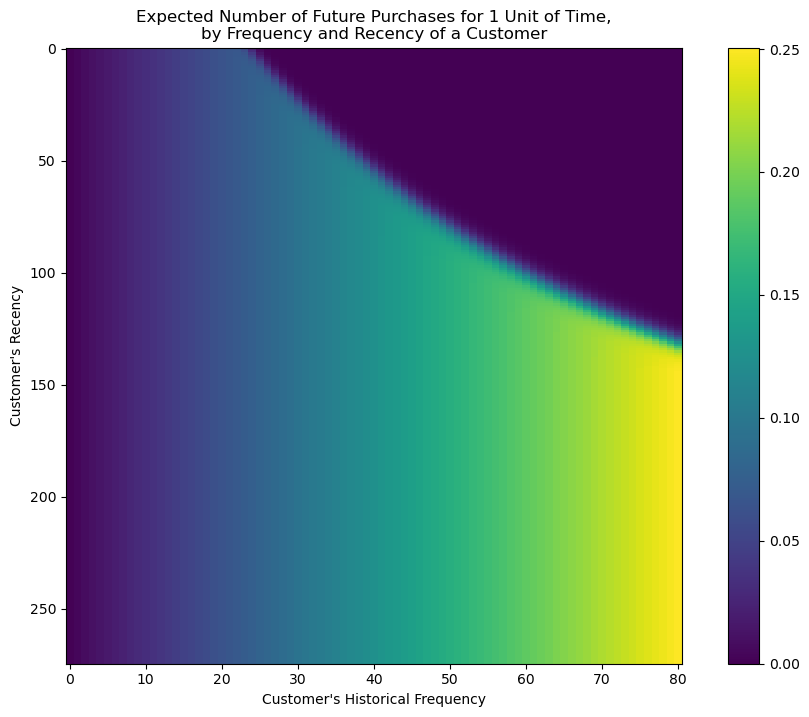

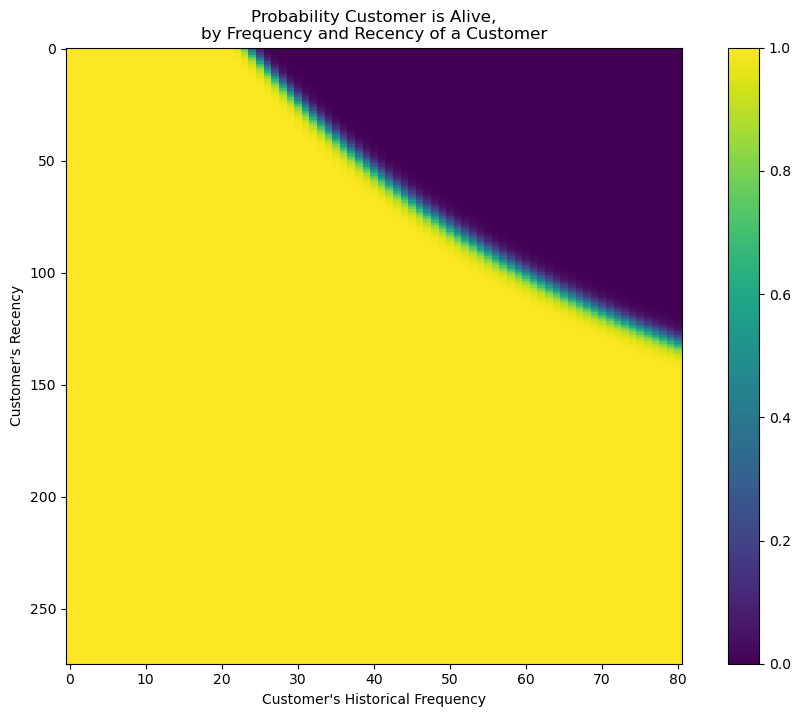

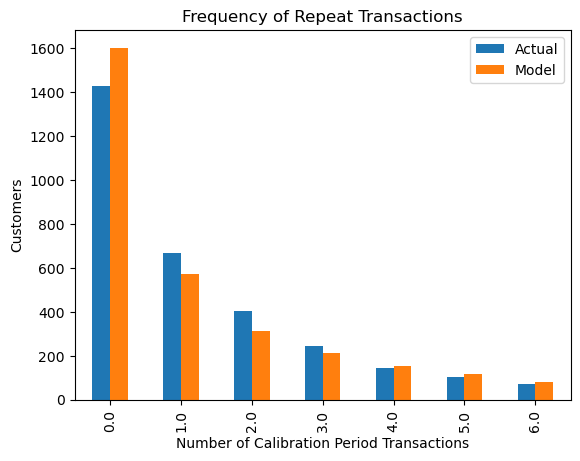

In [290]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

#predict a customer’s expected purchases in the next period using their history
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [291]:
df[df['CustomerID']==12346]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Revenue
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18,1.04,12346,United Kingdom,77183.6


In [292]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-08-31',
                                        observation_period_end='2011-11-30' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346                 0.0          0.0  225.0                0.0   
12347                 4.0        238.0  267.0                1.0   
12348                 2.0        110.0  258.0                1.0   
12350                 0.0          0.0  210.0                0.0   
12352                 3.0         34.0  196.0                3.0   

            duration_holdout  
CustomerID                    
12346                   91.0  
12347                   91.0  
12348                   91.0  
12350                   91.0  
12352                   91.0  


<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

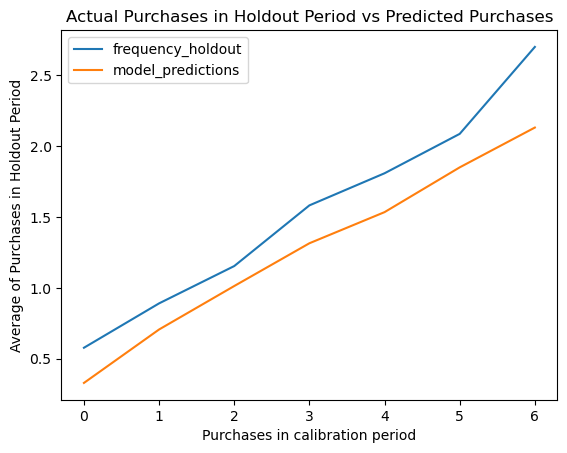

In [293]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

# Start here

In [294]:
from lifetimes.plotting import *
from lifetimes.utils import *
data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Revenue', observation_period_end='2011-09-01')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346,0.0,0.0,226.0,0.0000
12347,4.0,238.0,268.0,519.7675
12348,2.0,110.0,259.0,297.2200
12350,0.0,0.0,211.0,0.0000
12352,3.0,34.0,197.0,421.7700


In [295]:
cutoff_date = pd.to_datetime("2011-09-01").date()
end_date = pd.to_datetime("2011-12-01").date()

true_df = pd.DataFrame(df.loc[(df['InvoiceDate']>=cutoff_date)&(df['InvoiceDate']<end_date)]\
                       .groupby('CustomerID')['Revenue'].sum()).reset_index()
train_df = data.reset_index().merge(true_df).rename(columns={"Revenue":"y"})
train_df

,CustomerID,frequency,recency,T,monetary_value,y
0,12347,4.0,238.0,268.0,519.767500,1294.32
1,12348,2.0,110.0,259.0,297.220000,310.00
2,12352,3.0,34.0,197.0,421.770000,944.23
3,12356,1.0,80.0,226.0,481.460000,58.35
4,12359,2.0,142.0,232.0,1474.115000,2876.85
...,...,...,...,...,...,...
1873,18270,0.0,0.0,167.0,0.000000,171.20
1874,18272,3.0,133.0,147.0,488.876667,604.25
1875,18273,0.0,0.0,158.0,0.000000,102.00
1876,18283,7.0,189.0,238.0,125.331429,901.11


In [296]:
from lifetimes import BetaGeoFitter
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_df[['CustomerID','frequency',\
                                                      'recency',	'T','monetary_value']],\
                                                       train_df[['y']], test_size=0.3, random_state=42)
bgf = BetaGeoFitter(penalizer_coef=0.1)
bgf.fit(X_train['frequency'], X_train['recency'], X_train['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 1314 subjects, a: 0.00, alpha: 44.90, b: 0.00, r: 0.72>


In [297]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
15311,61.0,261.0,274.0,732.480164,0.193551
14606,64.0,270.0,274.0,142.672812,0.202959
12748,69.0,272.0,274.0,196.573913,0.218638
17841,73.0,274.0,274.0,303.863699,0.231181
14911,80.0,274.0,274.0,972.027875,0.253132


In [298]:
data['predicted_alive'] = bgf.conditional_probability_alive(data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_alive').head(5)

,frequency,recency,T,monetary_value,predicted_purchases,predicted_alive
CustomerID,,,,,,
17850,1.0,1.0,274.0,3891.87,0.005402,1.0
15332,1.0,3.0,270.0,63.00,0.005471,1.0
16499,1.0,4.0,265.0,147.35,0.005559,1.0
15224,1.0,4.0,263.0,310.48,0.005595,1.0
17198,1.0,6.0,272.0,249.65,0.005436,1.0


In [299]:
returning_customers_summary = X_train[X_train['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

      CustomerID  frequency  recency      T  monetary_value
1754       17838        2.0     80.0  273.0      485.270000
798        14715        1.0     33.0  232.0      109.500000
1820       18102       14.0    241.0  268.0     7472.632857
1469       16912        3.0    189.0  224.0      393.693333
58         12480        2.0    193.0  237.0      664.350000
961


In [300]:
returning_customers_summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,0.150443
frequency,0.150443,1.000000


In [301]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)


<lifetimes.GammaGammaFitter: fitted with 961 subjects, p: 3.18, q: 3.20, v: 302.83>


In [302]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        X_train['frequency'],
        X_train['monetary_value']
    ).mean(),
    X_train[X_train['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 451.5722540821905, Average profit: 451.71060514592483


In [303]:
pred_df = ggf.customer_lifetime_value(
    bgf, #the model to use to predict the number of future transactions
    X_test['frequency'],
    X_test['recency'],
    X_test['T'],
    X_test['monetary_value'],
    time=3, # months
    discount_rate=0 # monthly discount rate ~ 12.7% annually
).fillna(0)

pred_df

1111     175.167450
1448    2290.274120
1326     190.359216
807     1082.636798
270      336.737655
           ...     
1734     106.115523
358      107.717899
1041      89.477544
236      138.584806
551      154.324949
Name: clv, Length: 564, dtype: float64

In [304]:
from sklearn.metrics import mean_absolute_error
pred_df = pd.DataFrame(pred).reset_index()
bg_pred_df =pred_df.merge(y_test, left_index=True, right_index=True)
mean_absolute_error(bg_pred_df['y'], bg_pred_df['clv'])

1637.499686165309

In [305]:
bg_pred_df['y'].mean()

1538.4145360824741

# ML

In [306]:
from sklearn.ensemble import RandomForestRegressor
reg = RandomForestRegressor()
model = reg.fit(X_train.drop(columns='CustomerID'), y_train)


/var/folders/tw/8wdkdtvs1fv8ftrnn4f5vt540000gn/T/ipykernel_75904/548159121.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model = reg.fit(X_train.drop(columns='CustomerID'), y_train)
